# Pronostico fallecidos acumulados y diarios en Colombia de COVID-19

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
from keras.models import load_model

In [3]:
colombia = pd.read_csv('colombia.csv')
colombia

,fecha reporte web,ID de caso,Casos acumulados,Recuperados,Recuperados acumulados,Fallecidos,Fallecidos acumulados
0,2020-03-06,1,1,1,1,0,0
1,2020-03-07,0,1,0,1,0,0
2,2020-03-08,0,1,0,1,0,0
3,2020-03-09,2,3,2,3,0,0
4,2020-03-10,0,3,0,3,0,0
...,...,...,...,...,...,...,...
727,2022-03-03,1051,6068074,556,5899871,11,138792
728,2022-03-04,1351,6069425,780,5900651,23,138815
729,2022-03-05,1191,6070616,506,5901157,7,138822
730,2022-03-06,1088,6071704,574,5901731,3,138825


In [4]:

colombia.set_index('fecha reporte web', inplace = True)
colombia_fall = colombia.drop(['Casos acumulados', 'Recuperados', 'Recuperados acumulados','Fallecidos acumulados','ID de caso'],axis=1)
colombia_fall

,Fallecidos
fecha reporte web,
2020-03-06,0
2020-03-07,0
2020-03-08,0
2020-03-09,0
2020-03-10,0
...,...
2022-03-03,11
2022-03-04,23
2022-03-05,7


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(colombia_fall)
col_scaled_fall = scaler.transform(colombia_fall)

In [6]:
n_train_data = 670
n_test_data = 60

train_scaled_col_fall = col_scaled_fall[:n_train_data]
train_scaled_col_fall

test_scaled_col_fall = col_scaled_fall[n_train_data:n_train_data+n_test_data]
test_scaled_col_fall

array([[0.07608696],
       [0.1236413 ],
       [0.10597826],
       [0.10869565],
       [0.16168478],
       [0.13179348],
       [0.1576087 ],
       [0.2513587 ],
       [0.30298913],
       [0.28396739],
       [0.33559783],
       [0.31521739],
       [0.28804348],
       [0.41576087],
       [0.375     ],
       [0.45788043],
       [0.45516304],
       [0.39673913],
       [0.43206522],
       [0.29619565],
       [0.39945652],
       [0.32744565],
       [0.37092391],
       [0.35054348],
       [0.30163043],
       [0.30978261],
       [0.26358696],
       [0.32880435],
       [0.35461957],
       [0.22961957],
       [0.27309783],
       [0.21467391],
       [0.20244565],
       [0.19021739],
       [0.20923913],
       [0.19429348],
       [0.2486413 ],
       [0.10461957],
       [0.12907609],
       [0.11141304],
       [0.05978261],
       [0.09375   ],
       [0.09646739],
       [0.0923913 ],
       [0.07608696],
       [0.06793478],
       [0.0625    ],
       [0.048

In [7]:
from keras.preprocessing.sequence import TimeseriesGenerator

window_size= 60
n_features= 1
batch_size = 1

train_generator_col = TimeseriesGenerator(train_scaled_col_fall, train_scaled_col_fall, length= window_size, batch_size=batch_size)
print("Total number of samples in the original training data of Colombia = ", len(train_scaled_col_fall))
print("Total number of samples in the generated data of Colombia = ", len(train_generator_col))

test_generator_col = TimeseriesGenerator(test_scaled_col_fall , test_scaled_col_fall , length=len(test_scaled_col_fall )-1 ,batch_size=batch_size)
print("Total number of samples in the original training data of Colombia = ", len(test_scaled_col_fall ))
print("Total number of sambles in the generated data of Colombia", len(test_generator_col))

Total number of samples in the original training data of Colombia =  670
Total number of samples in the generated data of Colombia =  610
Total number of samples in the original training data of Colombia =  60
Total number of sambles in the generated data of Colombia 1


## Red neuronal simple

In [8]:
def model_rnn_builder(hp):
  model_rnn_col = keras.Sequential()
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model_rnn_col.add(LSTM(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='relu', input_shape=(window_size, n_features),return_sequences=True))
  model_rnn_col.add(LSTM(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='relu'))
  model_rnn_col.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_rnn_col.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_rnn_col

In [9]:
tuner = kt.BayesianOptimization(model_rnn_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_rnn',
                     project_name='hp_rnn_col')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_col, validation_data=test_generator_col,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 4 Complete [00h 38m 54s]
val_loss: nan

Best val_loss So Far: 9.045663318829611e-05
Total elapsed time: 02h 30m 18s
INFO:tensorflow:Oracle triggered exit


In [10]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 512 y el learning rate mas optimo será de 0.01.



In [11]:
model_rnn_col = tuner.hypermodel.build(best_hps)
history_rnn_col = model_rnn_col.fit(train_generator_col, epochs=100, validation_data=test_generator_col, callbacks=my_callbacks)

Epoch 1/100
610/610 [==============================] - 468s 763ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan - lr: 0.0100
Epoch 2/100
610/610 [==============================] - 465s 763ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan - lr: 0.0100
Epoch 3/100
610/610 [==============================] - 466s 764ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan - lr: 0.0100
Epoch 4/100
610/610 [==============================] - 465s 763ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan - lr: 0.0100
Epoch 5/100
610/610 [==============================] - 465s 762ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan - lr: 0.0100


In [12]:
model_rnn_col.save("model_rnn.h5")

Best epoch: 1


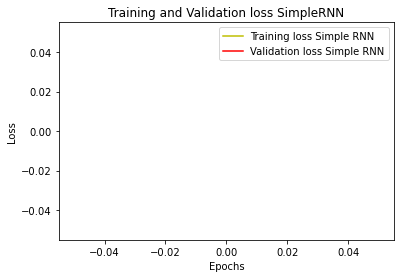

In [13]:
val_acc_per_epoch = history_rnn_col.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_rnn_col = history_rnn_col.history['loss']
val_loss_rnn_col = history_rnn_col.history['val_loss']
epochs = range(1,len(loss_rnn_col)+1)

plt.plot(epochs, loss_rnn_col, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_rnn_col, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
model_rnn_col = load_model('model_rnn.h5')

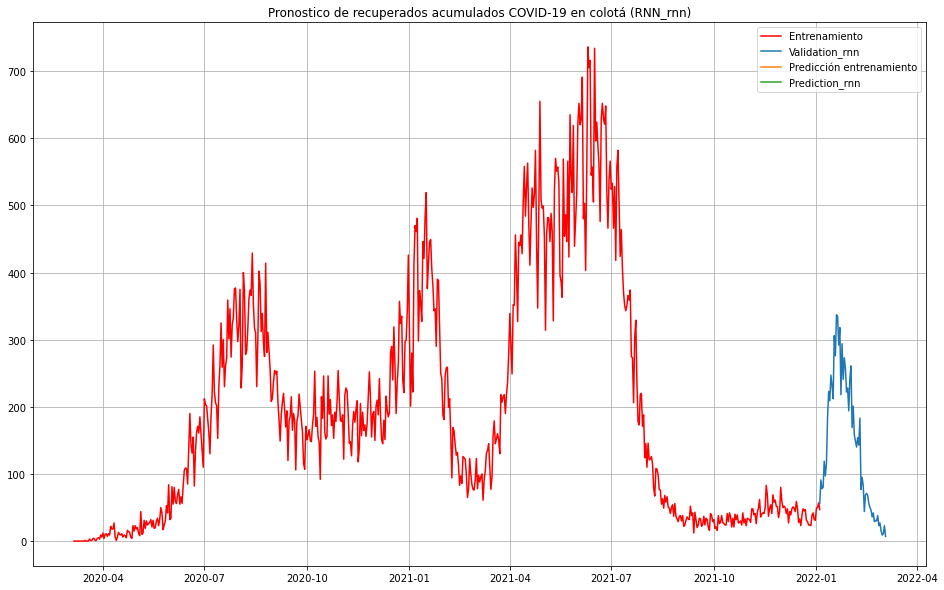

In [15]:
predictions_rnn_col = []

first_batch = test_scaled_col_fall[-window_size:]
current_batch_rnn_col = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_rnn_col = model_rnn_col.predict(current_batch_rnn_col)[0]
    

    predictions_rnn_col.append(current_pred_rnn_col)
    
    
    current_batch_rmv_first_rnn_col= current_batch_rnn_col[:,1:,:]
 

    current_batch_rnn_col= np.append(current_batch_rmv_first_rnn_col,[[current_pred_rnn_col]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_col_fall)
dates_train_data_rnn_col = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_rnn_col = pd.DataFrame({'Date':dates_train_data_rnn_col,'train':train_data_actual_scale[:,0]})
df_train_rnn_col.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_rnn_col = model_rnn_col.predict(train_generator_col)
train_prediction_data_actual_scale_rnn_col =scaler.inverse_transform(train_prediction_rnn_col)
dates_predict_train_data_rnn_col = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_rnn_col = pd.DataFrame({'Date':dates_predict_train_data_rnn_col,'train':train_prediction_data_actual_scale_rnn_col[:,0]})
df_predict_train_rnn_col.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_rnn_col = scaler.inverse_transform(test_scaled_col_fall)
dates_test_data_rnn_col = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_rnn_col = pd.DataFrame({'Date':dates_test_data_rnn_col,'Test_rnn_col':test_data_actual_scale_rnn_col[:,0]})
df_test_rnn_col.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_rnn_col = scaler.inverse_transform(predictions_rnn_col)
dates_predictions_rnn_col  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_rnn_col  = pd.DataFrame({'Date':dates_predictions_rnn_col,'Predictions_rnn_col':predictions_actual_scale_rnn_col[:,0]})
df_predictions_rnn_col .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_rnn_col,'r', label='Entrenamiento')
plt.plot(df_test_rnn_col['Test_rnn_col'], label='Validation_rnn')
plt.plot(df_predict_train_rnn_col['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en colotá (RNN_rnn)')
plt.plot(df_predictions_rnn_col ['Predictions_rnn_col'], label='Prediction_rnn')
plt.grid()
plt.legend()

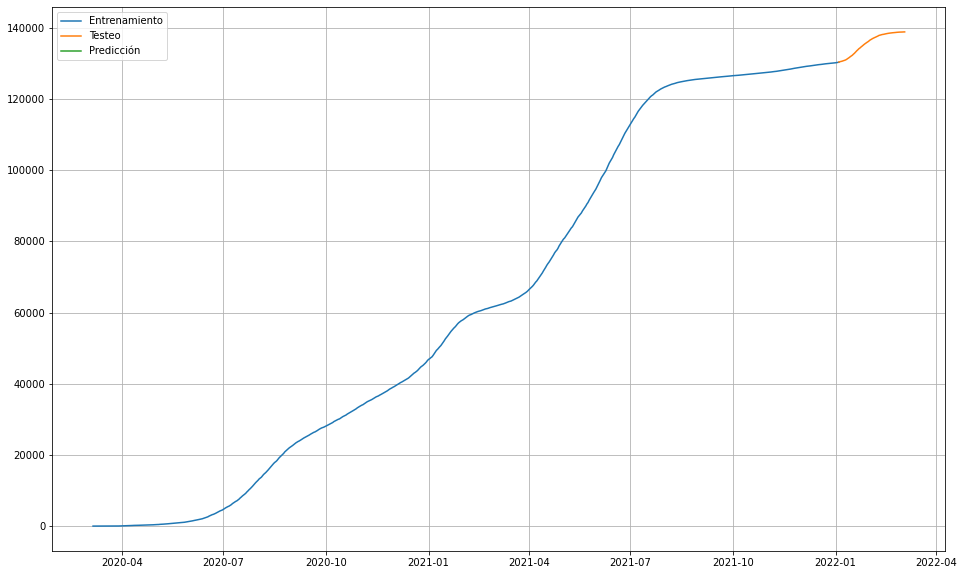

In [16]:
# Creación columna con casos acumulados.
df_predictions_rnn_col['acumulados']= df_predictions_rnn_col['Predictions_rnn_col'].cumsum()
df_predictions_rnn_col['acumulados'] = [i+colombia['Fallecidos acumulados'].max() for i in df_predictions_rnn_col.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_rnn_col['acumulados']=df_train_rnn_col['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_rnn_col['acumulados']=df_test_rnn_col['Test_rnn_col'].cumsum()
df_test_rnn_col['acumulados'] = [i+df_train_rnn_col['acumulados'].max() for i in df_test_rnn_col.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_rnn_col['acumulados'], label='Entrenamiento' )
plt.plot(df_test_rnn_col['acumulados'], label= 'Testeo')
plt.plot(df_predictions_rnn_col['acumulados'], label='Predicción')
plt.grid()
plt.legend()

In [17]:
df_predictions_rnn_col

,Predictions_rnn_col,acumulados
Date,,
2022-03-06,NaN,NaN
2022-03-07,NaN,NaN
2022-03-08,NaN,NaN
2022-03-09,NaN,NaN
2022-03-10,NaN,NaN
2022-03-11,NaN,NaN
2022-03-12,NaN,NaN
2022-03-13,NaN,NaN
2022-03-14,NaN,NaN


## Red neuronal con celdas LSTM

In [18]:
def model_lstm_builder(hp):
  model_lstm_col = keras.Sequential()
  hp_units = hp.Int('units', min_value=50, max_value=400, step=50)
  model_lstm_col.add(LSTM(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='relu', input_shape=(window_size, n_features),return_sequences=True))
  model_lstm_col.add(LSTM(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='relu'))
  model_lstm_col.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_lstm_col.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_lstm_col

In [19]:
tuner = kt.BayesianOptimization(model_lstm_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_lstm',
                     project_name='hp_lstm_col')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_col, validation_data=test_generator_col,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 4 Complete [00h 37m 06s]
val_loss: 0.012756653130054474

Best val_loss So Far: 0.012756653130054474
Total elapsed time: 01h 26m 18s
INFO:tensorflow:Oracle triggered exit


In [20]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 50 y el learning rate mas optimo será de 0.001.



In [21]:
model_lstm_col = tuner.hypermodel.build(best_hps)
history_lstm_col = model_lstm_col.fit(train_generator_col, epochs=100, validation_data=test_generator_col, callbacks=my_callbacks)


Epoch 1/100
610/610 [==============================] - 24s 36ms/step - loss: 0.0700 - root_mean_squared_error: 0.2487 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2277 - lr: 0.0010
Epoch 2/100
610/610 [==============================] - 21s 35ms/step - loss: 0.0491 - root_mean_squared_error: 0.2021 - val_loss: 0.0606 - val_root_mean_squared_error: 0.2289 - lr: 0.0010
Epoch 3/100
610/610 [==============================] - 21s 35ms/step - loss: 0.0456 - root_mean_squared_error: 0.1934 - val_loss: 0.0599 - val_root_mean_squared_error: 0.2274 - lr: 0.0010
Epoch 4/100
610/610 [==============================] - 21s 35ms/step - loss: 0.0423 - root_mean_squared_error: 0.1848 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2161 - lr: 0.0010
Epoch 5/100
610/610 [==============================] - 21s 35ms/step - loss: 0.0387 - root_mean_squared_error: 0.1746 - val_loss: 0.0502 - val_root_mean_squared_error: 0.2049 - lr: 0.0010
Epoch 6/100
610/610 [==============================] - 21s 3

In [22]:
model_lstm_col.save("model_lstm.h5")

Best epoch: 2


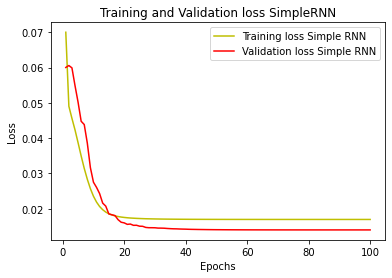

In [23]:
val_acc_per_epoch = history_lstm_col.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_lstm_col = history_lstm_col.history['loss']
val_loss_lstm_col = history_lstm_col.history['val_loss']
epochs = range(1,len(loss_lstm_col)+1)

plt.plot(epochs, loss_lstm_col, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_lstm_col, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
model_lstm_col = load_model('model_lstm.h5')

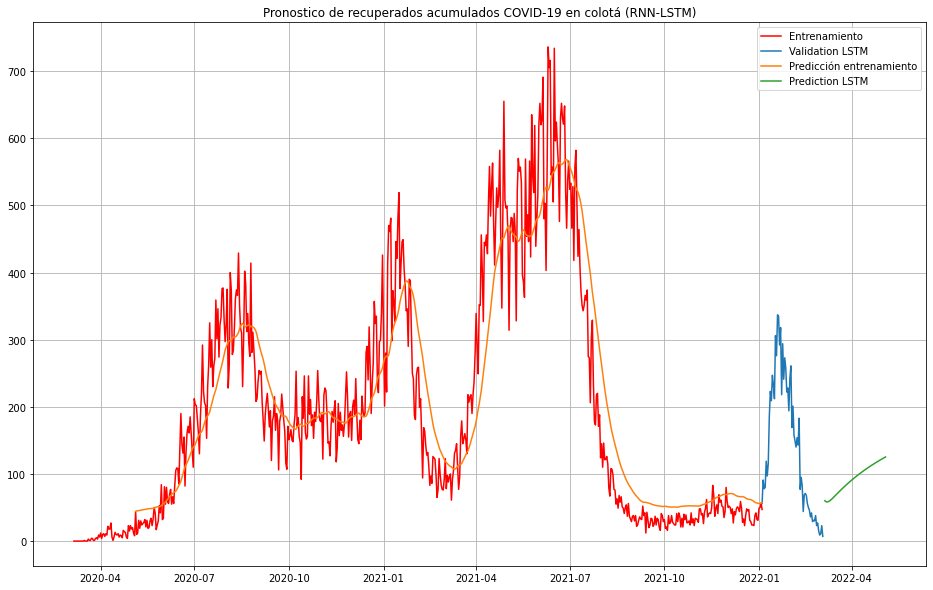

In [25]:
predictions_lstm_col = []

first_batch = test_scaled_col_fall[-window_size:]
current_batch_lstm_col = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_lstm_col = model_lstm_col.predict(current_batch_lstm_col)[0]
    

    predictions_lstm_col.append(current_pred_lstm_col)
    
    
    current_batch_rmv_first_lstm_col= current_batch_lstm_col[:,1:,:]
 

    current_batch_lstm_col= np.append(current_batch_rmv_first_lstm_col,[[current_pred_lstm_col]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_col_fall)
dates_train_data_lstm_col = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_lstm_col = pd.DataFrame({'Date':dates_train_data_lstm_col,'train':train_data_actual_scale[:,0]})
df_train_lstm_col.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_lstm_col = model_lstm_col.predict(train_generator_col)
train_prediction_data_actual_scale_lstm_col =scaler.inverse_transform(train_prediction_lstm_col)
dates_predict_train_data_lstm_col = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_lstm_col = pd.DataFrame({'Date':dates_predict_train_data_lstm_col,'train':train_prediction_data_actual_scale_lstm_col[:,0]})
df_predict_train_lstm_col.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_lstm_col = scaler.inverse_transform(test_scaled_col_fall)
dates_test_data_lstm_col = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_lstm_col = pd.DataFrame({'Date':dates_test_data_lstm_col,'Test_LSTM_col':test_data_actual_scale_lstm_col[:,0]})
df_test_lstm_col.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_lstm_col = scaler.inverse_transform(predictions_lstm_col)
dates_predictions_lstm_col  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_lstm_col  = pd.DataFrame({'Date':dates_predictions_lstm_col,'Predictions_LSTM_col':predictions_actual_scale_lstm_col[:,0]})
df_predictions_lstm_col .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_lstm_col,'r', label='Entrenamiento')
plt.plot(df_test_lstm_col['Test_LSTM_col'], label='Validation LSTM')
plt.plot(df_predict_train_lstm_col['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en colotá (RNN-LSTM)')
plt.plot(df_predictions_lstm_col ['Predictions_LSTM_col'], label='Prediction LSTM')
plt.grid()
plt.legend()

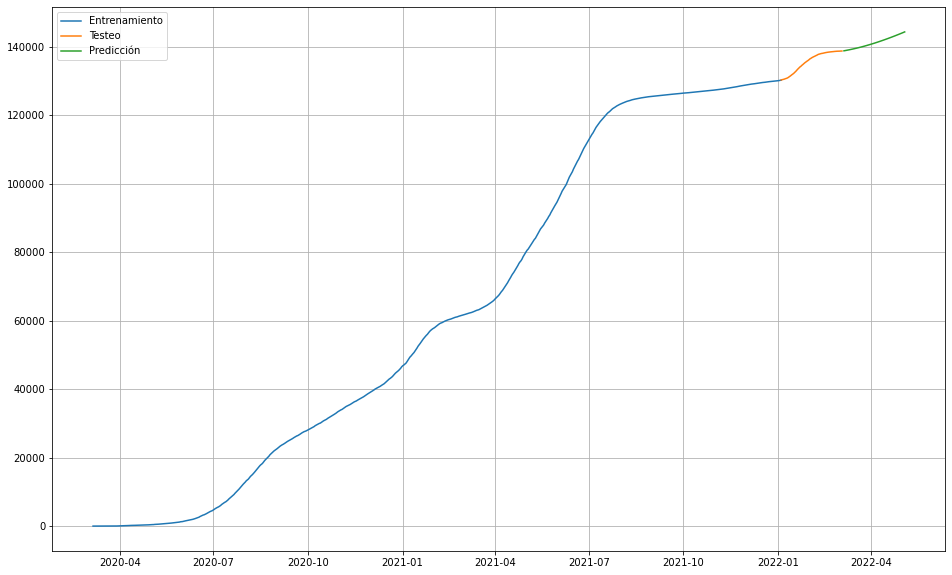

In [26]:
# Creación columna con casos acumulados.
df_predictions_lstm_col['acumulados']= df_predictions_lstm_col['Predictions_LSTM_col'].cumsum()
df_predictions_lstm_col['acumulados'] = [i+colombia['Fallecidos acumulados'].max() for i in df_predictions_lstm_col.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_lstm_col['acumulados']=df_train_lstm_col['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_lstm_col['acumulados']=df_test_lstm_col['Test_LSTM_col'].cumsum()
df_test_lstm_col['acumulados'] = [i+df_train_lstm_col['acumulados'].max() for i in df_test_lstm_col.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_lstm_col['acumulados'], label='Entrenamiento' )
plt.plot(df_test_lstm_col['acumulados'], label= 'Testeo')
plt.plot(df_predictions_lstm_col['acumulados'], label='Predicción')
plt.grid()
plt.legend()

In [27]:
df_predictions_lstm_col

,Predictions_LSTM_col,acumulados
Date,,
2022-03-06,60.195620,138885.195620
2022-03-07,58.742151,138943.937771
2022-03-08,58.297605,139002.235375
2022-03-09,58.555401,139060.790776
2022-03-10,59.290728,139120.081504
2022-03-11,60.345531,139180.427035
2022-03-12,61.610286,139242.037321
2022-03-13,63.008781,139305.046102
2022-03-14,64.488850,139369.534952


## Red neuronal con celdas GRU

In [12]:
def model_gru_builder(hp):
  model_gru_col = keras.Sequential()
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model_gru_col.add(GRU(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='tanh', input_shape=(window_size, n_features),return_sequences=True))
  model_gru_col.add(GRU(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='tanh'))
  model_gru_col.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_gru_col.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_gru_col

In [13]:
tuner = kt.BayesianOptimization(model_gru_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_gru',
                     project_name='hp_gru_col')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_col, validation_data=test_generator_col,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 4 Complete [00h 03m 22s]
val_loss: 9.185785165755078e-05

Best val_loss So Far: 9.185785165755078e-05
Total elapsed time: 02h 08m 00s
INFO:tensorflow:Oracle triggered exit


In [14]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 32 y el learning rate mas optimo será de 0.0001.



In [15]:
model_gru_col = tuner.hypermodel.build(best_hps)
history_gru_col = model_gru_col.fit(train_generator_col, epochs=100, validation_data=test_generator_col, callbacks=my_callbacks)

Epoch 1/100
610/610 [==============================] - 40s 54ms/step - loss: 0.0268 - root_mean_squared_error: 0.1504 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0601 - lr: 1.0000e-04
Epoch 2/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0085 - root_mean_squared_error: 0.0738 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0125 - lr: 1.0000e-04
Epoch 3/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0077 - root_mean_squared_error: 0.0722 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0113 - lr: 1.0000e-04
Epoch 4/100
610/610 [==============================] - 32s 52ms/step - loss: 0.0074 - root_mean_squared_error: 0.0730 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0275 - lr: 1.0000e-04
Epoch 5/100
610/610 [==============================] - 32s 53ms/step - loss: 0.0071 - root_mean_squared_error: 0.0718 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0305 - lr: 1.0000e-04
Epoch 6/100
610/610 [===================

In [16]:
model_gru_col.save("model_gru.h5")


Best epoch: 1


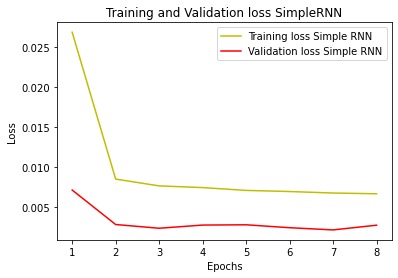

In [17]:
val_acc_per_epoch = history_gru_col.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_gru_col = history_gru_col.history['loss']
val_loss_gru_col = history_gru_col.history['val_loss']
epochs = range(1,len(loss_gru_col)+1)

plt.plot(epochs, loss_gru_col, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_gru_col, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
model_gru_col = load_model('model_gru.h5')

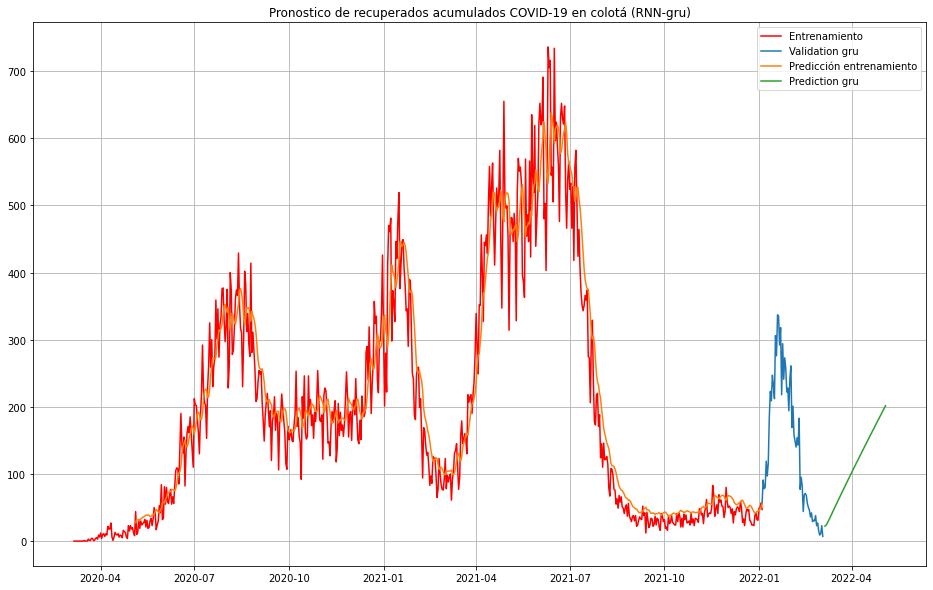

In [19]:
predictions_gru_col = []

first_batch = col_scaled_fall[-window_size:]
current_batch_gru_col = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_gru_col = model_gru_col.predict(current_batch_gru_col)[0]
    

    predictions_gru_col.append(current_pred_gru_col)
    
    
    current_batch_rmv_first_gru_col= current_batch_gru_col[:,1:,:]
 

    current_batch_gru_col= np.append(current_batch_rmv_first_gru_col,[[current_pred_gru_col]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_col_fall)
dates_train_data_gru_col = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_gru_col = pd.DataFrame({'Date':dates_train_data_gru_col,'train':train_data_actual_scale[:,0]})
df_train_gru_col.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_gru_col = model_gru_col.predict(train_generator_col)
train_prediction_data_actual_scale_gru_col =scaler.inverse_transform(train_prediction_gru_col)
dates_predict_train_data_gru_col = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_gru_col = pd.DataFrame({'Date':dates_predict_train_data_gru_col,'train':train_prediction_data_actual_scale_gru_col[:,0]})
df_predict_train_gru_col.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_gru_col = scaler.inverse_transform(test_scaled_col_fall)
dates_test_data_gru_col = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_gru_col = pd.DataFrame({'Date':dates_test_data_gru_col,'Test_gru_col':test_data_actual_scale_gru_col[:,0]})
df_test_gru_col.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_gru_col = scaler.inverse_transform(predictions_gru_col)
dates_predictions_gru_col  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_gru_col = pd.DataFrame({'Date':dates_predictions_gru_col,'Predictions_gru_col':predictions_actual_scale_gru_col[:,0]})
df_predictions_gru_col .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_gru_col,'r', label='Entrenamiento')
plt.plot(df_test_gru_col['Test_gru_col'], label='Validation gru')
plt.plot(df_predict_train_gru_col['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en colotá (RNN-gru)')
plt.plot(df_predictions_gru_col ['Predictions_gru_col'], label='Prediction gru')
plt.grid()
plt.legend()

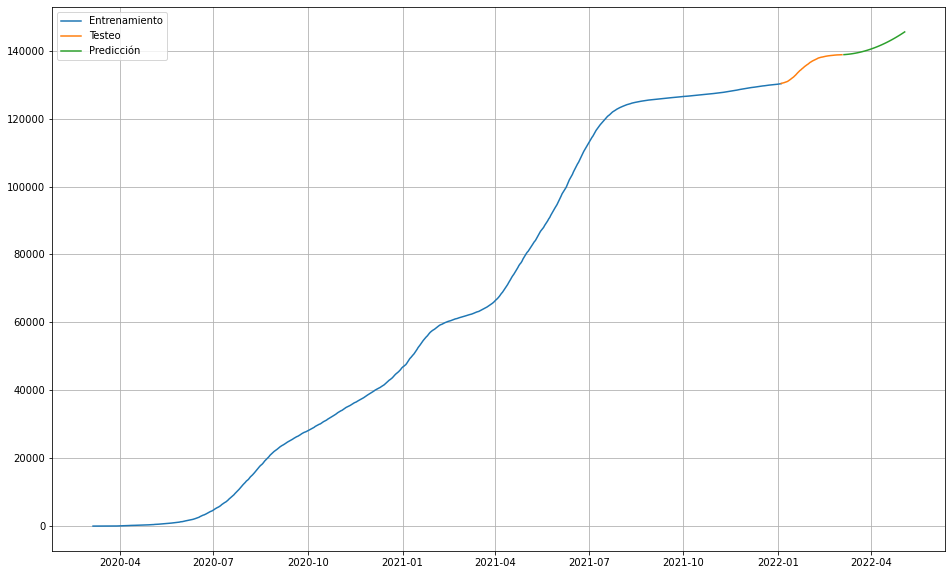

In [20]:
# Creación columna con casos acumulados.
df_predictions_gru_col['acumulados']= df_predictions_gru_col['Predictions_gru_col'].cumsum()
df_predictions_gru_col['acumulados'] = [i+colombia['Fallecidos acumulados'].max() for i in df_predictions_gru_col.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_gru_col['acumulados']=df_train_gru_col['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_gru_col['acumulados']=df_test_gru_col['Test_gru_col'].cumsum()
df_test_gru_col['acumulados'] = [i+df_train_gru_col['acumulados'].max() for i in df_test_gru_col.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_gru_col['acumulados'], label='Entrenamiento' )
plt.plot(df_test_gru_col['acumulados'], label= 'Testeo')
plt.plot(df_predictions_gru_col['acumulados'], label='Predicción')
plt.grid()
plt.legend()

In [21]:
df_predictions_gru_col

,Predictions_gru_col,acumulados
Date,,
2022-03-06,22.324406,138847.324406
2022-03-07,23.310011,138870.634418
2022-03-08,25.673987,138896.308404
2022-03-09,28.565662,138924.874067
2022-03-10,31.684264,138956.558331
2022-03-11,34.901086,138991.459417
2022-03-12,38.155786,139029.615203
2022-03-13,41.420105,139071.035308
2022-03-14,44.681563,139115.716871
